In [1]:
import os 
from Bio import SeqIO
import pickle
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import math

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

expName = "Test_Run_New_Dataset"
outPath = "Generated"

modelNames = ["DLNN_3", "DLNN_5", "DLNN_CORENup"]

epochs=200
batch_size = 64
shuffle = False
seed = None

dataset_path = "New_Dataset"
setting = "New_dataset"

In [4]:
##################################################################################
##### Load Training, Testing and Evaluation datasets
##################################################################################

## training data for the models
train_X = np.load("New_Dataset\\New_dataset\\train_X.npy")
train_y = np.load("New_Dataset\\New_dataset\\train_y.npy")

## validation dataset for the models
eval_X = np.load("New_Dataset\\New_dataset\\eval_X.npy")
eval_y = np.load("New_Dataset\\New_dataset\\eval_y.npy")

## testing dataset for the models
test_X = np.load("New_Dataset\\New_dataset\\test_X.npy")
test_y = np.load("New_Dataset\\New_dataset\\test_y.npy")

print("Training samples:",train_X.shape[0])
print("Testing samples:",test_X.shape[0])
print("Evaluation samples:",eval_X.shape[0])

print("Datapoint shape:",[train_X.shape[1], train_X.shape[2]])

# Data is already one-hot-encoded

Training samples: 22166
Testing samples: 6928
Evaluation samples: 5542
Datapoint shape: [99, 21]


In [5]:
train_y_1d = np.array([xi[0] for xi in train_y])
eval_y_1d = np.array([xi[0] for xi in eval_y])
test_y_1d = np.array([xi[0] for xi in test_y])

In [6]:
##################################################################################
##### define evaluator functions
##################################################################################

# ## Build the K-fold from dataset
# def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
#     skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
#     kfoldList = []
#     for train_index, test_index in skf.split(features, labels):
#         X_train, X_test = features[train_index], features[test_index]
#         y_train, y_test = labels[train_index], labels[test_index]
#         kfoldList.append({
#             "X_train": X_train,
#             "X_test": X_test,
#             "y_train":y_train,
#             "y_test":y_test
#         })
#     return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

In [7]:
##################################################################################
##### Function to generate the DLNN-X and CORENup network architectures with parameters
##################################################################################

def Conv_LSTM_DLNN(input_shape=(150,4), conv_filters_per_layer = 50, kernel_length = 5, lstm_decode_units = 50, 
                   learn_rate = 0.0003, prob = 0.5, loss = 'binary_crossentropy', metrics = None, max_pool_width = 2, 
                   max_pool_stride = 2, dense_decode_units = 150):
    
    beta = 0.001
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv1D(conv_filters_per_layer, kernel_length, input_shape = input_shape, 
                                     kernel_regularizer=tf.keras.regularizers.l2(beta), padding="same"))
    
    model.add(tf.keras.layers.MaxPool1D(pool_size = max_pool_width, strides = max_pool_stride))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                                   kernel_regularizer = tf.keras.regularizers.l2(beta), dropout = 0.1))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras .layers.Flatten())

    model.add(tf.keras.layers.Dense(dense_decode_units, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='relu'))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='sigmoid'))
    
    #[tf.keras.metrics.binary_accuracy, metrics.precision, metrics.recall, metrics.f1score])
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss, metrics = metrics) 
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)

    return model

def DLNN_CORENup(input_shape = (150,4),
                 conv_filters_per_layer_1 = 50, kernel_length_1 = 5, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
                 lstm_decode_units = 50, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 50,  kernel_length_2 = 10, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
                 dense_decode_units = 370, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None):
    
    beta = 0.001
    
    input1 = tf.keras.layers.Input(shape = input_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1, input_shape = input_shape, 
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              dropout=0.1)(x1)
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## LSTM Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)

    ## Fully connected Layers

    y = tf.keras.layers.Concatenate(1)([x2,x3])
    
    y1 = tf.keras.layers.Dense(dense_decode_units, kernel_regularizer = tf.keras.regularizers.l2(beta), activation = 'relu')(y)
    
    y1 = tf.keras.layers.Dropout(prob)(y1)
    
    y1 = tf.keras.layers.Dense(1, kernel_regularizer = tf.keras.regularizers.l2(beta), activation = 'sigmoid')(y1)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=[input1], outputs=y1)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr=learn_rate), loss = loss)

    return model

In [8]:
##################################################################################
##### For each model, train and generate generate evaluation metrics
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Kernel_Length" : [],
    "Dataset" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

input_shape = train_X[0].shape

for modelName in modelNames:
    if modelName == "DLNN_CORENup":
        kernel_length = "5,10"
        model = DLNN_CORENup(input_shape = input_shape)
    
    else:
        kernel_length = int(modelName[-1])
        model = Conv_LSTM_DLNN(input_shape = input_shape, conv_filters_per_layer = 50, kernel_length = kernel_length, 
                               lstm_decode_units = 50, learn_rate = 0.0003, prob = 0.5, loss='binary_crossentropy', 
                               metrics=None)
    
    modelPath = os.path.join(outPath, expName, "Models")
    if(not os.path.isdir(modelPath)):
        os.makedirs(modelPath)
    
    print("===============================================================================================")
    print("Model", modelName, "initialized.")
    
    ## Define the model callbacks for early stopping and saving the model. Then train model 
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}.hdf5".format(modelName)),
                                           monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                         mode = 'auto', baseline = None, restore_best_weights = False)
    ]
    model.fit(x = train_X, y = train_y_1d, batch_size = batch_size, epochs = epochs, verbose = 1, 
              callbacks = modelCallbacks, validation_data = (eval_X, eval_y_1d))
    
    print("\nModel", modelName, "Trained.")
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################
    
    y_pred = model.predict(train_X)
    label_pred = pred2label(y_pred)
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(train_y_1d, label_pred)
    prec = precision_score(train_y_1d,label_pred)

    conf = confusion_matrix(train_y_1d, label_pred)
    if(conf[0][0]+conf[1][0]):
        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
    else:
        sens = 0.0
    if(conf[1][1]+conf[0][1]):
        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
    else:
        spec = 0.0
    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
    else:
        mcc= 0.0
    fpr, tpr, thresholds = roc_curve(train_y_1d, y_pred)
    auc = roc_auc_score(train_y_1d, y_pred)

    evaluations["Model"].append(modelName)
    evaluations["Kernel_Length"].append(kernel_length)
    evaluations["Dataset"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    print("Prediction and Evaluation on TRAIN dataset done for",modelName,"model.")
    
    ##################################################################################
    ##### Prediction and metrics for EVAL dataset
    ##################################################################################
    
    y_pred = model.predict(eval_X)
    label_pred = pred2label(y_pred)
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(eval_y_1d, label_pred)
    prec = precision_score(eval_y_1d,label_pred)

    conf = confusion_matrix(eval_y_1d, label_pred)
    if(conf[0][0]+conf[1][0]):
        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
    else:
        sens = 0.0
    if(conf[1][1]+conf[0][1]):
        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
    else:
        spec = 0.0
    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
    else:
        mcc= 0.0
    fpr, tpr, thresholds = roc_curve(eval_y_1d, y_pred)
    auc = roc_auc_score(eval_y_1d, y_pred)

    evaluations["Model"].append(modelName)
    evaluations["Kernel_Length"].append(kernel_length)
    evaluations["Dataset"].append("Eval")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    print("Prediction and Evaluation on EVAL dataset done for",modelName,"model.")
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################
    
    y_pred = model.predict(test_X)
    label_pred = pred2label(y_pred)
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(test_y_1d, label_pred)
    prec = precision_score(test_y_1d,label_pred)

    conf = confusion_matrix(test_y_1d, label_pred)
    if(conf[0][0]+conf[1][0]):
        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
    else:
        sens = 0.0
    if(conf[1][1]+conf[0][1]):
        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
    else:
        spec = 0.0
    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
    else:
        mcc= 0.0
    fpr, tpr, thresholds = roc_curve(test_y_1d, y_pred)
    auc = roc_auc_score(test_y_1d, y_pred)

    evaluations["Model"].append(modelName)
    evaluations["Kernel_Length"].append(kernel_length)
    evaluations["Dataset"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    print("Prediction and Evaluation on TEST dataset done for",modelName,"model.")
    
    del model
    tf.keras.backend.clear_session()
    
##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "_Evaluation_All_Models_Datasets.pickle"), "wb"))

Model DLNN_3 initialized.
Epoch 1/200
347/347 [==============================] - 2s 7ms/step - loss: 0.8727 - val_loss: 0.7184
Epoch 2/200
347/347 [==============================] - 2s 5ms/step - loss: 0.6902 - val_loss: 0.6244
Epoch 3/200
347/347 [==============================] - 2s 5ms/step - loss: 0.6268 - val_loss: 0.5804
Epoch 4/200
347/347 [==============================] - 2s 5ms/step - loss: 0.5942 - val_loss: 0.5519
Epoch 5/200
347/347 [==============================] - 2s 5ms/step - loss: 0.5728 - val_loss: 0.5435
Epoch 6/200
347/347 [==============================] - 2s 5ms/step - loss: 0.5521 - val_loss: 0.5335
Epoch 7/200
347/347 [==============================] - 2s 5ms/step - loss: 0.5410 - val_loss: 0.5172
Epoch 8/200
347/347 [==============================] - 2s 5ms/step - loss: 0.5331 - val_loss: 0.5073
Epoch 9/200
347/347 [==============================] - 2s 5ms/step - loss: 0.5276 - val_loss: 0.5073
Epoch 10/200
347/347 [==============================] - 2s 5ms/st

Epoch 36/200
347/347 [==============================] - 2s 5ms/step - loss: 0.4521 - val_loss: 0.4544
Epoch 37/200
347/347 [==============================] - 2s 6ms/step - loss: 0.4523 - val_loss: 0.4543

Model DLNN_5 Trained.
Prediction and Evaluation on TRAIN dataset done for DLNN_5 model.
Prediction and Evaluation on EVAL dataset done for DLNN_5 model.
Prediction and Evaluation on TEST dataset done for DLNN_5 model.
Model DLNN_CORENup initialized.
Epoch 1/200
347/347 [==============================] - 3s 8ms/step - loss: 1.1145 - val_loss: 0.8643
Epoch 2/200
347/347 [==============================] - 2s 6ms/step - loss: 0.7923 - val_loss: 0.6996
Epoch 3/200
347/347 [==============================] - 2s 6ms/step - loss: 0.6808 - val_loss: 0.6300
Epoch 4/200
347/347 [==============================] - 2s 6ms/step - loss: 0.6199 - val_loss: 0.5762
Epoch 5/200
347/347 [==============================] - 2s 6ms/step - loss: 0.5880 - val_loss: 0.5605
Epoch 6/200
347/347 [===================

## Visualization of Evaluation

In [9]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd
import math


In [10]:
##################################################################################
##### Parameters used only in this section
##################################################################################

expName = "Test_Run_New_Dataset"
outPath = "Generated"

modelNames = ["DLNN_3", "DLNN_5", "DLNN_CORENup"]

In [11]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

evaluations = pickle.load(open(os.path.join(evalPath, "_Evaluation_All_Models_Datasets.pickle"), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [12]:
evaluations_df

,Model,Kernel_Length,Dataset,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,DLNN_3,3,Train,0.829875,0.875153,"[0.0, 8.96780557797507e-05, 0.0172181867097121...","[0.0, 0.0, 0.0, 9.078529278256922e-05, 9.07852...","[1.9990027, 0.99900275, 0.9822449, 0.9822313, ...",0.914581,0.793755,0.875153,0.664673
1,DLNN_3,3,Eval,0.813244,0.846764,"[0.0, 0.000370919881305638, 0.0192878338278931...","[0.0, 0.0, 0.0, 0.00035137034434293746, 0.0003...","[1.998431, 0.9984309, 0.98204756, 0.98126894, ...",0.899368,0.787734,0.846764,0.628860
2,DLNN_3,3,Test,0.818418,0.853854,"[0.0, 0.0002881014116969173, 0.017574186113511...","[0.0, 0.0, 0.0, 0.0002892681515765114, 0.00028...","[1.9980738, 0.9980738, 0.9850781, 0.98498976, ...",0.901970,0.789266,0.853854,0.640070
3,DLNN_5,5,Train,0.839258,0.868278,"[0.0, 8.96780557797507e-05, 0.0071742444623800...","[0.0, 0.0, 0.0, 9.078529278256922e-05, 9.07852...","[1.9991145, 0.9991146, 0.9937278, 0.993652, 0....",0.919098,0.814059,0.868278,0.680654
4,DLNN_5,5,Eval,0.816312,0.831621,"[0.0, 0.000370919881305638, 0.0430267062314540...","[0.0, 0.0, 0.0, 0.00035137034434293746, 0.0003...","[1.9986666, 0.99866664, 0.9791268, 0.97895986,...",0.898650,0.803453,0.831621,0.632899
5,DLNN_5,5,Test,0.825924,0.845380,"[0.0, 0.0002881014116969173, 0.031403053874963...","[0.0, 0.0, 0.0, 0.0002892681515765114, 0.00028...","[1.9989741, 0.9989741, 0.9842477, 0.98417884, ...",0.902018,0.808441,0.845380,0.652889
6,DLNN_CORENup,"5,10",Train,0.834070,0.899412,"[0.0, 8.96780557797507e-05, 0.0064568200161420...","[0.0, 0.0, 0.0, 9.078529278256922e-05, 9.07852...","[1.9987928, 0.99879277, 0.9876816, 0.98762393,...",0.924370,0.786355,0.899412,0.677394
7,DLNN_CORENup,"5,10",Eval,0.806748,0.859354,"[0.0, 0.000370919881305638, 0.0330118694362017...","[0.0, 0.0, 0.0, 0.00035137034434293746, 0.0003...","[1.9965618, 0.9965618, 0.97324014, 0.9731352, ...",0.901429,0.770497,0.859354,0.619318
8,DLNN_CORENup,"5,10",Test,0.814809,0.870596,"[0.0, 0.0002881014116969173, 0.030250648228176...","[0.0, 0.0, 0.0, 0.0002892681515765114, 0.00028...","[1.9977965, 0.99779654, 0.9761234, 0.9760661, ...",0.903915,0.773390,0.870596,0.636915


In [13]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Model", 
                                                 "Dataset"]).mean().filter(['Accuracy',
                                                                          'Precision', 
                                                                          'AUC', 
                                                                          'Sensitivity', 
                                                                          'Specificity', 
                                                                          'MCC'])

DLNN_3_DF = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), ['DLNN_3'])]
DLNN_5_DF = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), ['DLNN_5'])]
DLNN_CORENup_DF = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), ['DLNN_CORENup'])]

In [14]:
DLNN_CORENup_DF

Accuracy  Precision       AUC  Sensitivity  Specificity  \
Model        Dataset                                                            
DLNN_CORENup Eval     0.806748   0.859354  0.901429     0.770497     0.859354   
             Test     0.814809   0.870596  0.903915     0.773390     0.870596   
             Train    0.834070   0.899412  0.924370     0.786355     0.899412   

                           MCC  
Model        Dataset            
DLNN_CORENup Eval     0.619318  
             Test     0.636915  
             Train    0.677394

#### Select a metric to plot below:

In [15]:
metric_to_plot = "Accuracy"

In [16]:
DLNN_CORENup_DF.index.get_level_values(1)

Index(['Eval', 'Test', 'Train'], dtype='object', name='Dataset')

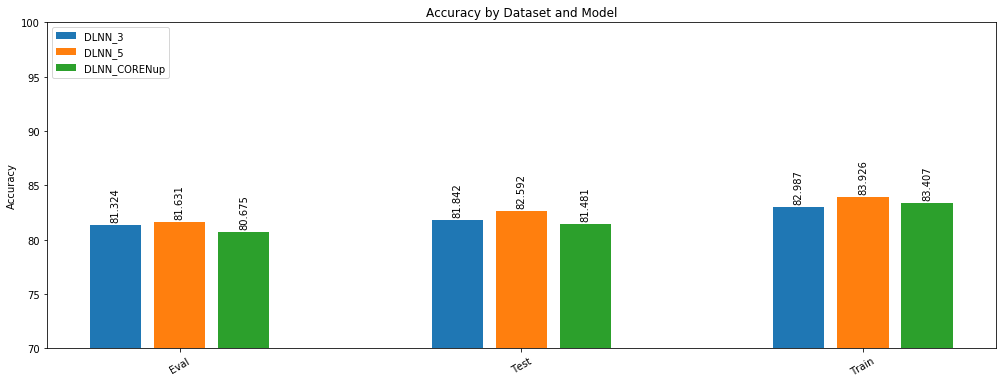

In [17]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(DLNN_CORENup_DF[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(x - (2.5*(width/2)), round(DLNN_3_DF[metric_to_plot]*100, 3), width, label='DLNN_3')
rects2 = ax.bar(x + (0*(width/2)), round(DLNN_5_DF[metric_to_plot]*100, 3), width, label='DLNN_5')
rects3 = ax.bar(x + (2.5*(width/2)), round(DLNN_CORENup_DF[metric_to_plot]*100, 3), width, label='DLNN_CORENup')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
            (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
# ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
# ax.set_xticklabels([m+" - "+str(n) for m,n in 
#                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
#                   rotation=30)
ax.set_xticklabels(DLNN_CORENup_DF.index.get_level_values(1),
                  rotation=30)


ax.set_title(metric_to_plot+' by Dataset and Model')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

### Store all metrics' plots to file

In [18]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    x = np.arange(len(DLNN_CORENup_DF[metric_to_plot]))
    width = 0.15

    fig, ax = plt.subplots(figsize=(17,6))
    rects1 = ax.bar(x - (2.5*(width/2)), round(DLNN_3_DF[metric_to_plot]*100, 3), width, label='DLNN_3')
    rects2 = ax.bar(x + (0*(width/2)), round(DLNN_5_DF[metric_to_plot]*100, 3), width, label='DLNN_5')
    rects3 = ax.bar(x + (2.5*(width/2)), round(DLNN_CORENup_DF[metric_to_plot]*100, 3), width, label='DLNN_CORENup')

    ## Custom y-axis tick labels
    ax.set_ylabel(metric_to_plot)
    ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
                (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
    # ax.set_ylim([80, 105])

    ## Custom x-axis tick labels
    ax.set_xticks(x)
    # ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
    # ax.set_xticklabels([m+" - "+str(n) for m,n in 
    #                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
    #                   rotation=30)
    ax.set_xticklabels(DLNN_CORENup_DF.index.get_level_values(1),
                      rotation=30)


    ax.set_title(metric_to_plot+' by Dataset and Model')
    ax.legend(loc='upper left')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", 
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    
    plt.savefig(os.path.join(evalPath, "{}_Comparison".format(metric_to_plot)))
    plt.close()
    